In [1]:
import joblib
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
ITER = 10
TRAIN = True
NC = [20, 30, 40, 50]

### 探究困惑度和主题个数的关系

In [3]:
df = pd.read_csv('./data/Twitter.csv').sample(frac=1/10)

ps = []
components = [i for i in range(1, 101)]
vectorizer = TfidfVectorizer(max_features=5000)
tfidf = vectorizer.fit_transform(df['content'].values.tolist())

for idx, n_component in enumerate(tqdm(components)):
    lda = LatentDirichletAllocation(n_components=n_component, max_iter=ITER, random_state=42)
    lda.fit(tfidf)
    p = lda.perplexity(tfidf)
    ps.append(p)

100%|█████████████████████████████████████████| 100/100 [28:17<00:00, 16.97s/it]


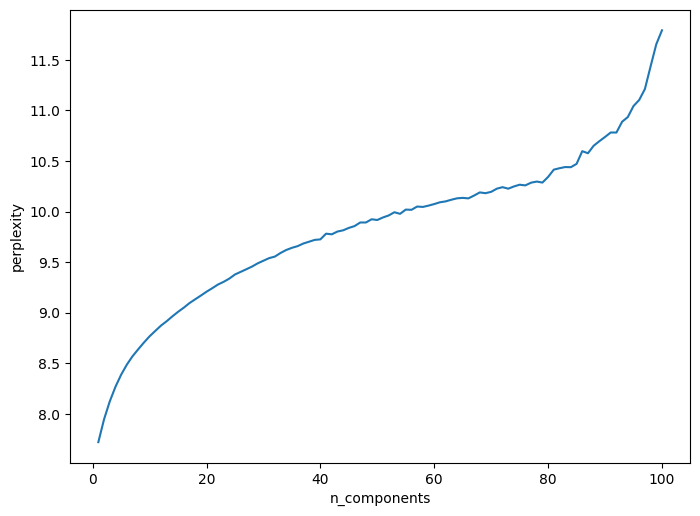

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(components, list(map(lambda x: np.log(x), ps)))
plt.xlabel('n_components')
plt.ylabel('perplexity')
plt.savefig('./result/lda/perplexity.jpg')
plt.show()

### 以 Year 为分析粒度

#### 中文数据集

In [5]:
# 获得 tfidf 编码
df = pd.read_csv('./data/Weibo.csv')
vectorizer = TfidfVectorizer(max_features=5000)
tfidf = vectorizer.fit_transform(df['content'].values.tolist())

# 训练模型
if TRAIN:
    perplexity = np.inf
    for n_component in NC:
        s = time()
        lda = LatentDirichletAllocation(n_components=n_component, max_iter=ITER, random_state=42)
        lda.fit(tfidf)
        p = lda.perplexity(tfidf)
        e = time()
        if p < perplexity:
            perplexity = p
            print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} | save model...'.format(e-s, n_component, p))
            joblib.dump(lda, './result/lda/2020/ch/lda.pkl') 
        else:
            print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} |'.format(e-s, n_component, p))
lda = joblib.load('./result/lda/2020/ch/lda.pkl')      

# 主题-词语 分布矩阵
words = vectorizer.get_feature_names_out()
df_t2w = pd.DataFrame(lda.components_, columns=words)
df_t2w.to_csv('./result/lda/2020/ch/theme2word.csv', index=False)

# 文档-主题 分布矩阵
df_d2t = pd.DataFrame(lda.transform(tfidf))
df_d2t['month'] = df['month'].copy()
df_d2t['day'] = df['day'].copy()
df_d2t.to_csv('./result/lda/2020/ch/doc2theme.csv', index=False)

Cost: 306.1365 | Ncomponents: 20 | Perplexity: 4289.9284 | save model...
Cost: 304.0646 | Ncomponents: 30 | Perplexity: 4667.2733 |
Cost: 306.4631 | Ncomponents: 40 | Perplexity: 5113.0415 |
Cost: 320.8585 | Ncomponents: 50 | Perplexity: 5760.5615 |


#### 英文数据集

In [6]:
# 获得 tfidf 编码
df = pd.read_csv('./data/Twitter.csv')
vectorizer = TfidfVectorizer(max_features=5000)
tfidf = vectorizer.fit_transform(df['content'].values.tolist())

# 训练模型
if TRAIN:
    perplexity = np.inf
    for n_component in NC:
        s = time()
        lda = LatentDirichletAllocation(n_components=n_component, max_iter=ITER, random_state=42)
        lda.fit(tfidf)
        p = lda.perplexity(tfidf)
        e = time()
        if p < perplexity:
            perplexity = p
            print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} | save model...'.format(e-s, n_component, p))
            joblib.dump(lda, './result/lda/2020/en/lda.pkl') 
        else:
            print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} |'.format(e-s, n_component, p))
lda = joblib.load('./result/lda/2020/en/lda.pkl')      

# 主题-词语 分布矩阵
words = vectorizer.get_feature_names_out()
df_t2w = pd.DataFrame(lda.components_, columns=words)
df_t2w.to_csv('./result/lda/2020/en/theme2word.csv', index=False)

# 文档-主题 分布矩阵
df_d2t = pd.DataFrame(lda.transform(tfidf))
df_d2t['month'] = df['month'].copy()
df_d2t['day'] = df['day'].copy()
df_d2t.to_csv('./result/lda/2020/en/doc2theme.csv', index=False)

Cost: 155.9565 | Ncomponents: 20 | Perplexity: 6954.1079 | save model...
Cost: 154.2982 | Ncomponents: 30 | Perplexity: 8976.2584 |
Cost: 157.9518 | Ncomponents: 40 | Perplexity: 10891.7789 |
Cost: 161.4998 | Ncomponents: 50 | Perplexity: 12480.9800 |


### 以 Month 为分析粒度

In [7]:
months = ['202001', '202002', '202003', '202004', '202005', '202006', 
          '202007', '202008', '202009', '202010', '202011', '202012',]

#### 中文数据集

In [8]:
df = pd.read_csv('./data/Weibo.csv')

for idx, (month, tmp_df) in enumerate(df.groupby('month')):
    tmp_df = tmp_df.reset_index().drop(columns=['index'])
    
    month = months[idx]
    print(month)
    
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf = vectorizer.fit_transform(tmp_df['content'].values.tolist())

    # 训练模型
    if TRAIN:
        perplexity = np.inf
        for idx, n_component in enumerate(NC):
            s = time()
            lda = LatentDirichletAllocation(n_components=n_component, max_iter=ITER, random_state=42)
            lda.fit(tfidf)
            p = lda.perplexity(tfidf)
            e = time()
            if p < perplexity:
                perplexity = p
                print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} | save model...'.format(e-s, n_component, p))
                joblib.dump(lda, './result/lda/'+str(month)+'/ch/lda.pkl') 
            else:
                print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} |'.format(e-s, n_component, p))
    lda = joblib.load('./result/lda/'+str(month)+'/ch/lda.pkl')      

    # 主题-词语 分布矩阵
    words = vectorizer.get_feature_names_out()
    df_t2w = pd.DataFrame(lda.components_, columns=words)
    df_t2w.to_csv('./result/lda/'+str(month)+'/ch/theme2word.csv', index=False)

    # 文档-主题 分布矩阵
    df_d2t = pd.DataFrame(lda.transform(tfidf))
    df_d2t['month'] = tmp_df['month'].copy()
    df_d2t['day'] = tmp_df['day'].copy()
    df_d2t.to_csv('./result/lda/'+str(month)+'/ch/doc2theme.csv', index=False)
    print('==================================================================')

202001
Cost: 28.8461 | Ncomponents: 20 | Perplexity: 2379.3309 | save model...
Cost: 28.5285 | Ncomponents: 30 | Perplexity: 2573.3279 |
Cost: 29.1387 | Ncomponents: 40 | Perplexity: 2814.3535 |
Cost: 29.9367 | Ncomponents: 50 | Perplexity: 3032.3758 |
202002
Cost: 56.2041 | Ncomponents: 20 | Perplexity: 3635.6967 | save model...
Cost: 55.3575 | Ncomponents: 30 | Perplexity: 4137.0886 |
Cost: 55.9513 | Ncomponents: 40 | Perplexity: 4902.3098 |
Cost: 95.3475 | Ncomponents: 50 | Perplexity: 5392.9131 |
202003
Cost: 40.9792 | Ncomponents: 20 | Perplexity: 5152.5163 | save model...
Cost: 40.7931 | Ncomponents: 30 | Perplexity: 6204.6120 |
Cost: 41.7515 | Ncomponents: 40 | Perplexity: 7648.2080 |
Cost: 42.3075 | Ncomponents: 50 | Perplexity: 8722.6681 |
202004
Cost: 46.5189 | Ncomponents: 20 | Perplexity: 2996.7826 | save model...
Cost: 47.2391 | Ncomponents: 30 | Perplexity: 3409.8424 |
Cost: 47.4731 | Ncomponents: 40 | Perplexity: 3873.6097 |
Cost: 50.0779 | Ncomponents: 50 | Perplexity: 

#### 英文数据集

In [9]:
df = pd.read_csv('./data/Twitter.csv')

for idx, (month, tmp_df) in enumerate(df.groupby('month')):
    tmp_df = tmp_df.reset_index().drop(columns=['index'])
    
    month = months[idx]
    print(month)
    
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf = vectorizer.fit_transform(tmp_df['content'].values.tolist())

    # 训练模型
    if TRAIN:
        perplexity = np.inf
        for idx, n_component in enumerate(NC):
            s = time()
            lda = LatentDirichletAllocation(n_components=n_component, max_iter=ITER, random_state=42)
            lda.fit(tfidf)
            p = lda.perplexity(tfidf)
            e = time()
            if p < perplexity:
                perplexity = p
                print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} | save model...'.format(e-s, n_component, p))
                joblib.dump(lda, './result/lda/'+str(month)+'/en/lda.pkl') 
            else:
                print('Cost: {0:.4f} | Ncomponents: {1} | Perplexity: {2:.4f} |'.format(e-s, n_component, p))
    lda = joblib.load('./result/lda/'+str(month)+'/en/lda.pkl')      

    # 主题-词语 分布矩阵
    words = vectorizer.get_feature_names_out()
    df_t2w = pd.DataFrame(lda.components_, columns=words)
    df_t2w.to_csv('./result/lda/'+str(month)+'/en/theme2word.csv', index=False)

    # 文档-主题 分布矩阵
    df_d2t = pd.DataFrame(lda.transform(tfidf))
    df_d2t['month'] = tmp_df['month'].copy()
    df_d2t['day'] = tmp_df['day'].copy()
    df_d2t.to_csv('./result/lda/'+str(month)+'/en/doc2theme.csv', index=False)
    print('==================================================================')

202001
Cost: 0.0165 | Ncomponents: 20 | Perplexity: 3769.7629 | save model...
Cost: 0.0163 | Ncomponents: 30 | Perplexity: 5973.8603 |
Cost: 0.0171 | Ncomponents: 40 | Perplexity: 8578.9534 |
Cost: 0.0173 | Ncomponents: 50 | Perplexity: 9469.1602 |
202002
Cost: 0.0447 | Ncomponents: 20 | Perplexity: 10667.8981 | save model...
Cost: 0.0469 | Ncomponents: 30 | Perplexity: 17768.5947 |
Cost: 0.0502 | Ncomponents: 40 | Perplexity: 25287.4475 |
Cost: 0.0519 | Ncomponents: 50 | Perplexity: 35867.6820 |
202003
Cost: 10.8661 | Ncomponents: 20 | Perplexity: 10451.0059 | save model...
Cost: 10.9545 | Ncomponents: 30 | Perplexity: 13802.2386 |
Cost: 11.0208 | Ncomponents: 40 | Perplexity: 17203.6745 |
Cost: 11.3118 | Ncomponents: 50 | Perplexity: 20617.6255 |
202004
Cost: 22.7119 | Ncomponents: 20 | Perplexity: 8861.4653 | save model...
Cost: 22.4079 | Ncomponents: 30 | Perplexity: 11737.0503 |
Cost: 22.5635 | Ncomponents: 40 | Perplexity: 14537.6114 |
Cost: 22.9233 | Ncomponents: 50 | Perplexity